# Data Exploration: `Intermediate_data_01`

#### Objectives:
1. What is the distribution of the number of times each gene is sampled?
2. What is the distribution of the proportion of papers that found >2-fold difference for each gene?
3. Are we looking at substantially diminishing returns of new unique candidate genes per dataset processed already?
4. What proportion of TAG synthesis pathway genes are included in this set of unique genes?

#### Method:

1. Iterate through intermediate datasets to collect "candidate genes."
2. 

y-axis: number of unique candidate genes


#### New candidate_gene inclusion criteria:
- showed up as `True` in at least **one comparison per paper** AND in at least **two papers**

x-axis: number of datasets

In [1]:
import pickle
import random
import pandas as pd
import numpy as np
import statistics as stats
import random
from matplotlib import pyplot as plt
import time
import re

In [2]:
p = open("../../data/intermediate_data_02/matches", "rb")
matches = pickle.load(p)
match_summary = pd.read_csv("../../data/intermediate_data_02/match_summary.csv")
match_summary["firstauthor_year"] = match_summary["first_author"] + "_"+match_summary["year"].astype(int).astype(str)
print(match_summary)

  first_author    year  matches  mismatches    total  proportion_of_matches  \
0        Hemme  2014.0   1894.0        86.0   1980.0               0.956566   
1     Bajhaiya  2016.0  17736.0         1.0  17737.0               0.999944   
2   Goodenough  2014.0     66.0         2.0     68.0               0.970588   
3        Blaby  2013.0    591.0        51.0    642.0               0.920561   
4        Boyle  2012.0     24.0         1.0     25.0               0.960000   
5     Juergens  2015.0     96.0         9.0    105.0               0.914286   
6         Kwak  2017.0    850.0         0.0    850.0               1.000000   
7     Gargouri  2015.0    414.0         0.0    414.0               1.000000   

  firstauthor_year  
0       Hemme_2014  
1    Bajhaiya_2016  
2  Goodenough_2014  
3       Blaby_2013  
4       Boyle_2012  
5    Juergens_2015  
6        Kwak_2017  
7    Gargouri_2015  


### Categorize gene_ids as candidate genes based on cut-off

`Candidate_gene` new criteria: detected as candidate gene in **at least one comparison per paper** AND in **at least two papers**


In [13]:
#random.seed(1)
#random.shuffle()
cut_off = 0.75
num_papers = 8
count = 0
list_temp =[]
candidates = {}

#### 1. What is the distribution of the number of times each gene is sampled?

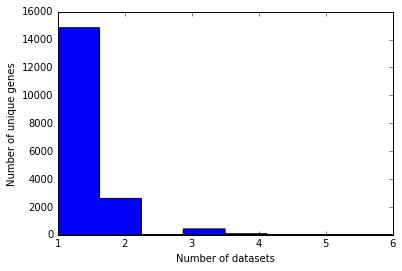

In [14]:
#Distribution of number of times each gene is sampled
temp = []
dict_temp = dict([(key, 0) for key in [i for i in range(num_papers+1)]])
i = 0
for gene in matches.keys():
    count = len(matches[gene])
    temp.append(count)
    dict_temp[count]+=1
    #print(count)
    #if i> 10: break
    
fig, ax = plt.subplots()
plt.hist(temp, bins = 8, histtype = 'stepfilled')
ax.set_xlabel('Number of datasets')
ax.set_ylabel('Number of unique genes')
plt.savefig('distribution_of_genes_detected.png', bbox_inches = "tight", dpi = 300)

In [15]:
dict_temp2 = {'count': list(dict_temp.keys()), 
            'number_of_genes': list(dict_temp.values())}
df= pd.DataFrame.from_dict(dict_temp2)
print("Count = number of studies that sampled a gene")
print (df)
#print( np.percentile(temp,98))

Count = number of studies that sampled a gene
   count  number_of_genes
0      0                0
1      1            14843
2      2             2607
3      3              421
4      4               75
5      5                9
6      6                1
7      7                0
8      8                0


#### 2. What is the distribution of the proportion of papers that found >2-fold difference for each gene?

- After filtering out genes sampled by only one paper

In [31]:
#random.seed(1)
#random.shuffle()
num_papers = 8
count = 0
p_true =[]
candidates = {}
for gene in matches.keys():
    
    #Only consider genes sampled by at least two papers
    if len(matches[gene])>1:
        
        #Proportion of papers that found >2-fold difference for each gene
        tmp = [dataset.split(':')[1] for value in matches[gene] for dataset in [value]]
        tmp = [1 if int(i)>0 else 0 for i in tmp]
        p_true = sum(tmp)/num_papers
        list_temp.append(p_true)
        
        #Create sub-dictionary of genes with at least two papers that fold>2-fold difference for each gene
        if sum(tmp) >= 2: candidates[gene] = matches[gene]
        else: pass
        
        
    else: pass 
    #if included > 0.5: print(included)


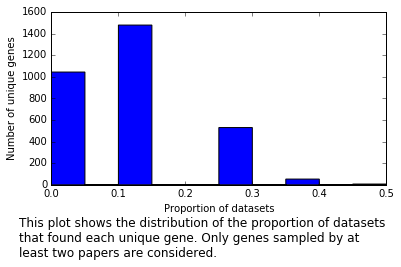

In [30]:
fig, ax = plt.subplots()
plt.hist(list_temp, bins = 10, histtype = 'stepfilled')
ax.set_xlabel('Proportion of datasets')
ax.set_ylabel('Number of unique genes')
caption ="This plot shows the distribution of the proportion of datasets\nthat found each unique gene. Only genes sampled by at\n least two papers are considered."
plt.subplots_adjust(bottom=0.3)
plt.figtext(0.05, 0.05, caption, fontsize=12, ha = 'left', wrap = True )
plt.savefig('Proportion_of_datasets.png', bbox_inches = "tight", dpi = 300)


In [8]:
print("Total number of candidates after filtering: ", len(candidates.keys()))

Total number of candidates after filtering:  590


#### 3. Are we looking at substantially diminishing returns of new unique candidate genes per dataset processed already?

Simulate dataset collection by randomly sample all datasets without replacements and calculate the number of new unique candidate genes per dataset. Repeat this simulation `rep` times.

`uniq` dictionary structure:

`uniq = { [ nth sampled dataset <int> ] : number of unique candidate genes <int> }`

In [9]:
omit = []
rep = 100
uniq = dict((key,[0]*rep) for key in range(1,len(list(np.unique(match_summary.firstauthor_year)))+1))
#print(uniq)

In [10]:
t0 = time.time()
shuffled_ls = list(match_summary.firstauthor_year)
for r in range(rep):
    
    #Randomly reorder datasets
    random.seed(r)
    random.shuffle(shuffled_ls)
    
    #Keep a list of sampled datasets
    omit = []
    
    for i in range(len(shuffled_ls)):
    
        for gene in candidates.keys():
            
            #If sample dataset is in candidates[gene] and none of the sampled datasets in omit list is in candidates[gene], number of unique candidate genes detected by the dataset +1.
            if any(shuffled_ls[i] in value for value in candidates[gene]) and any(counted in value for value in candidates[gene] for counted in omit) ==False :
                
                uniq[i+1][r]+=1

            else: pass
        
        #Add sampled dataset to omit list once all the genes have been accounted for
        omit.append(shuffled_ls[i])
            
t1 = time.time()    
print("Simulation of", rep, "times took", t1-t0, "sec.")

Simulation of 100 times took 0.6718635559082031 sec.


Convert `uniq` dictionary to `df` dataframe. 

**`df`** dataframe structure:


| 1         	| 2                   	| 3                             	| ... 	| `rep` 	| average 	| SD 	|
|-----------------------------------------	|-------              	|-------                        	|-------	|-------	|----------------------	|----------------------------------	|
| cumsum(number of unique genes)<br>`<int>` 	| `<int>` 	| `<int>` 	| `<int>` 	| `<int>` 	| RowAverage <br>`<int>` 	| RowStandardDeviation <br>`<float>` 	|

**`rep`**: `<int>` number of simulations

In [11]:
df = pd.DataFrame.from_dict(uniq, orient = "index")
for col in df.columns:
    df[col] = df[col].cumsum()
df['average'] = df.mean(axis=1)

df['SD'] = df[df.columns[range(rep)]].std(axis=1)

In [13]:
col_names = ['dataset_num', 'cumsum']
reshaped_df= pd.DataFrame(columns = col_names)

for col in df.columns[range(rep)]:
    
    temp = df[col].reset_index()
    temp.columns =['dataset_num', 'cumsum']
    #temp['cumsum'] = temp['unique_genes'].cumsum()
    reshaped_df= pd.concat([reshaped_df, temp])
    
#print(reshaped_df)

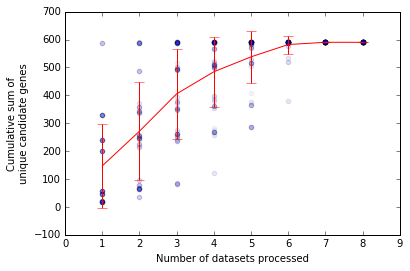

In [16]:
fig, ax = plt.subplots()

plt.scatter(x='dataset_num', y='cumsum', data = reshaped_df, alpha = 0.05, zorder =2)
ax.errorbar(list(df.index), list(df.average),
       yerr=list(df.SD),
       alpha=1,
       color='red',
       capsize=5)
ax.set_xlabel('Number of datasets processed')
ax.set_ylabel('Cumulative sum of\nunique candidate genes')
#plt.show()
plt.savefig('cumulative_unique_genes.png', bbox_inches = "tight", dpi = 300)

#### 4. What proportion of TAG synthesis pathway genes are included in this set of unique genes?
*C. reinhardtii* TAG synthesis pathway genes are downloaded from BioCyc (accessed on May 20, 2020)

In [73]:
#Import TAG synthesis pathway genes
TAG_genes= pd.read_csv("../../data/raw_data/lipid_pathway_genes/triacylglycerol_biosynthesis.txt",skiprows = 1, delimiter = "\t")
TAG_genes = pd.Series(TAG_genes["Enzymatic activity"].values, index=TAG_genes["Gene Accession"]).to_dict()

print("Number of TAG synthesis pathway genes:", len(TAG_genes))

Number of TAG synthesis pathway genes: 26


In [74]:
candidate_TAG_genes ={}
for key in candidates.keys():
    if key in TAG_genes: candidate_TAG_genes[key] = TAG_genes[key]
print("Number of TAG synthesis pathway genes detected as candidate genes:", len(candidate_TAG_genes),'\n' ,candidate_TAG_genes)

Number of TAG synthesis pathway genes detected as candidate genes: 4 
 {'Cre09.g386912.t1.1': 'diacylglycerol O-acyltransferase', 'Cre02.g106400.t1.1': 'phospholipid:diacylglycerol acyltransferase', 'Cre12.g557750.t1.1': 'diacylglycerol O-acyltransferase', 'Cre01.g045903.t1.1': 'diacylglycerol O-acyltransferase'}


### Export dictionary of unique genes with dataset information to `data/intermediate_data_02/`

In [70]:
pickle_out = open("../../data/intermediate_data_02/unique", "wb")
pickle.dump(uniq, pickle_out)
pickle_out.close()